In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt # Pour d'éventuelles visualisations
import seaborn as sns # Pour d'éventuelles visualisations

# Téléchargement initial des ressources NLTK (à faire une fois par environnement)
# nltk.download('stopwords', quiet=True)
# nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


# Pour Word2Vec
from gensim.models import Word2Vec

# Pour les Réseaux de Neurones avec Keras (TensorFlow backend)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, GlobalAveragePooling1D, Dropout, Bidirectional, Input
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Pour les Transformers (Hugging Face)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import evaluate

# Configuration
SEED = 42 # Pour la reproductibilité
np.random.seed(SEED)
tf.random.set_seed(SEED)
# torch.manual_seed(SEED) # Si vous utilisez PyTorch plus directement

# Affichage des dataframes
pd.set_option('display.max_colwidth', 200)

2025-05-10 06:46:15.877513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746859575.899735     104 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746859575.905695     104 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746859575.922962     104 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746859575.922982     104 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746859575.922984     104 computation_placer.cc:177] computation placer alr

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
module 'pyarrow.lib' has no attribute 'ListViewType'

In [8]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt # Pour d'éventuelles visualisations
import seaborn as sns # Pour d'éventuelles visualisations

# 1. Chargement et Préparation des Données

Le dataset utilisé est "TimKoornstra/financial-tweets-sentiment" de Hugging Face, contenant des tweets financiers avec des labels de sentiment (positif, négatif, neutre).

In [9]:
print("--- 1. Chargement et Préparation des Données ---")
import pandas as pd
try:
    # Assurez-vous d'être connecté à Hugging Face si le dataset est privé ou nécessite une authentification
    # from huggingface_hub import notebook_login
    # notebook_login() # Décommentez si nécessaire
    df = pd.read_parquet("hf://datasets/TimKoornstra/financial-tweets-sentiment/data/train-00000-of-00001.parquet")
except Exception as e:
    print(f"Erreur de chargement du dataset depuis Hugging Face: {e}")
    print("Utilisation d'un dataset d'exemple simplifié.")
    # Fallback dataset pour les tests hors ligne ou si le chargement échoue
    data_dict = {
        'tweet': [
            "Stock market is soaring with $AAPL!", "This company $XYZ is doing great.", "I am neutral about this $TSLA.",
            "Feeling bearish about the economy.", "Lost a lot of money today with $GME.", "This is a disaster for $BTC.",
            "Positive news for $MSFT.", "Neutral stance on $AMZN.", "Negative outlook for $NVDA.",
            "Great earnings report from $GOOG.", "Uncertainty looms over the $SPX index.", "Significant drop in $OIL prices."
        ] * 100, # Multiplier pour avoir plus de données
        'sentiment': [1, 1, 0, 2, 2, 2, 1, 0, 2, 1, 0, 2] * 100
    }
    df = pd.DataFrame(data_dict)

if 'url' in df.columns:
    df.drop(columns=['url'], inplace=True)
df.rename(columns={'sentiment': 'label_orig_int'}, inplace=True)
df.rename(columns={'tweet': 'text'}, inplace=True)

map_labels_str = {0: "neutral", 1: 'positive',  2: 'negative'}
df['label'] = df['label_orig_int'].apply(lambda x: map_labels_str.get(x, "unknown")) # .get pour gérer les labels inconnus

# Supprimer les lignes avec des labels "unknown" si elles existent
df = df[df['label'] != "unknown"]
df.reset_index(drop=True, inplace=True)

print("Dataset chargé.")

--- 1. Chargement et Préparation des Données ---
Dataset chargé.


Aperçu du DataFrame:


,text,label_orig_int,label
0,$BYND - JPMorgan reels in expectations on Beyo...,2,negative
1,$CCL $RCL - Nomura points to bookings weakness...,2,negative
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",2,negative
3,$ESS: BTIG Research cuts to Neutral https://t....,2,negative
4,$FNKO - Funko slides after Piper Jaffray PT cu...,2,negative



Informations sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38091 entries, 0 to 38090
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            38091 non-null  object
 1   label_orig_int  38091 non-null  int64 
 2   label           38091 non-null  object
dtypes: int64(1), object(2)
memory usage: 892.9+ KB

Distribution des labels:
label
positive    17368
neutral     12181
negative     8542
Name: count, dtype: int64


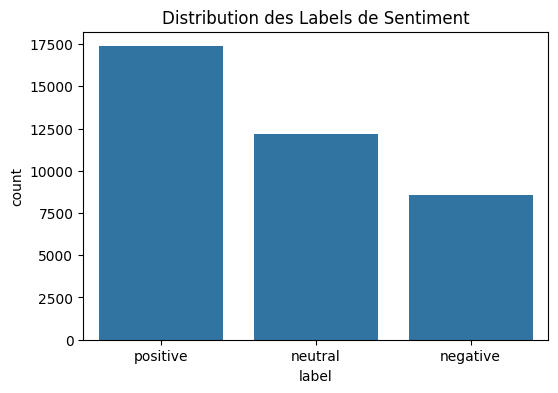

In [10]:
print("Aperçu du DataFrame:")
display(df.head())

print("\nInformations sur le DataFrame:")
df.info()

print("\nDistribution des labels:")
print(df['label'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, order = df['label'].value_counts().index)
plt.title('Distribution des Labels de Sentiment')
plt.show()

# 2. Nettoyage du Texte

Les étapes de nettoyage incluent :

    Passage en minuscules.

    Suppression des URLs.

    Suppression des mentions (@) et hashtags (#) (on garde le mot du hashtag).

    Suppression de la ponctuation.

    (Optionnel) Suppression des stop-words (peut être géré par les vectoriseurs).

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

from sklearn.model_selection import train_test_split, GridSearchCV

print("--- 2. Nettoyage du Texte ---")
stop_words_en = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) # Supprime URLs
    text = re.sub(r"\@\w+", "", text) # Supprime mentions
    # text = re.sub(r"#", "", text) # Conserve le mot après le hashtag, supprime juste le #
    text = text.translate(str.maketrans("", "", string.punctuation.replace('$',''))) # Conserve le $ pour les tickers
    text = re.sub(r"\s+", " ", text).strip() # Supprime les espaces multiples
    # Optionnel: suppression des stop words (peut être fait plus tard ou par le vectoriseur)
    # tokens = word_tokenize(text)
    # tokens = [word for word in tokens if word not in stop_words_en and word.isalpha()]
    # text = " ".join(tokens)
    return text

--- 2. Nettoyage du Texte ---


In [13]:
df["cleaned_text"] = df["text"].apply(clean_text)
print("Exemples de texte nettoyé :")
display(df[["text", "cleaned_text"]].head())

Exemples de texte nettoyé :


,text,cleaned_text
0,$BYND - JPMorgan reels in expectations on Beyo...,$bynd jpmorgan reels in expectations on beyond...
1,$CCL $RCL - Nomura points to bookings weakness...,$ccl $rcl nomura points to bookings weakness a...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",$cx cemex cut at credit suisse jp morgan on we...
3,$ESS: BTIG Research cuts to Neutral https://t....,$ess btig research cuts to neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,$fnko funko slides after piper jaffray pt cut


### 3. Séparation des Données Train/Test

Nous divisons les données en ensembles d'entraînement et de test (80%/20%) en veillant à stratifier par label pour maintenir la proportion des classes.

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, GlobalAveragePooling1D, Dropout, Bidirectional, Input
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

SEED = 42 # Pour la reproductibilité
np.random.seed(SEED)
tf.random.set_seed(SEED)


print("--- 3. Séparation Train/Test ---")
X = df["cleaned_text"]
y_str = df["label"]
y_int = df["label_orig_int"] # Sera utilisé pour les NN et Transformers

# Encoder les labels string en int pour certains modèles sklearn si besoin,
# mais classification_report peut utiliser les strings.
label_encoder_global = LabelEncoder()
y_encoded_for_split = label_encoder_global.fit_transform(y_str)


X_train_text, X_test_text, y_train_str, y_test_str, y_train_int, y_test_int, y_train_encoded, y_test_encoded = train_test_split(
    X, y_str, y_int, y_encoded_for_split, test_size=0.2, random_state=SEED, stratify=y_str
)

print(f"Taille de l'ensemble d'entraînement: {len(X_train_text)}")
print(f"Taille de l'ensemble de test: {len(X_test_text)}")
print(f"Distribution des labels dans y_train_str:\n{y_train_str.value_counts(normalize=True)}")
print(f"Distribution des labels dans y_test_str:\n{y_test_str.value_counts(normalize=True)}")

2025-05-12 16:23:14.827222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747066994.900271     338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747066994.927420     338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747066995.065507     338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747066995.065529     338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747066995.065530     338 computation_placer.cc:177] computation placer alr

--- 3. Séparation Train/Test ---
Taille de l'ensemble d'entraînement: 30472
Taille de l'ensemble de test: 7619
Distribution des labels dans y_train_str:
label
positive    0.455960
neutral     0.319802
negative    0.224239
Name: proportion, dtype: float64
Distribution des labels dans y_test_str:
label
positive    0.455965
neutral     0.319727
negative    0.224308
Name: proportion, dtype: float64


# 4. Modèles "Classiques" avec Scikit-learn

Nous allons commencer par évaluer des modèles de classification textuelle plus traditionnels.

In [20]:
results_summary = {}

def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    print(f"Rapport de Classification pour {model_name}:")
    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=label_encoder_global.classes_)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_global.classes_, yticklabels=label_encoder_global.classes_)
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()

    results_summary[model_name] = {
        'accuracy': accuracy,
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score']
    }

### 4.a. Naive Bayes (Multinomial) avec TF-IDF

Le classifieur Naive Bayes est un modèle probabiliste simple mais souvent efficace pour la classification de texte. Nous utilisons MultinomialNB qui est adapté aux comptes de mots ou fréquences (TF-IDF). 

--- 4.a. Naive Bayes (Multinomial) ---
Rapport de Classification pour Naive Bayes (TF-IDF):
              precision    recall  f1-score   support

    negative       0.67      0.47      0.55      1709
     neutral       0.71      0.68      0.69      2436
    positive       0.69      0.82      0.75      3474

    accuracy                           0.70      7619
   macro avg       0.69      0.66      0.67      7619
weighted avg       0.69      0.70      0.69      7619



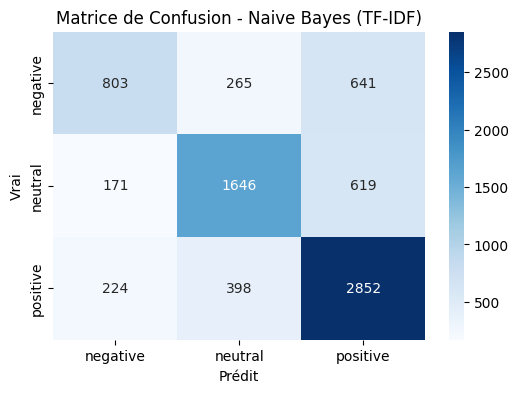

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("--- 4.a. Naive Bayes (Multinomial) ---")
tfidf_vectorizer_nb = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf_nb = tfidf_vectorizer_nb.fit_transform(X_train_text)
X_test_tfidf_nb = tfidf_vectorizer_nb.transform(X_test_text)

nb_model = MultinomialNB(alpha=0.1) # alpha est un hyperparamètre à régler
# GridSearchCV pour Naive Bayes
# params_nb = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
# grid_nb = GridSearchCV(MultinomialNB(), params_nb, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_nb.fit(X_train_tfidf_nb, y_train_str)
# nb_model = grid_nb.best_estimator_
# print(f"Meilleurs paramètres pour Naive Bayes: {grid_nb.best_params_}")
nb_model.fit(X_train_tfidf_nb, y_train_str)

y_pred_nb = nb_model.predict(X_test_tfidf_nb)
evaluate_model("Naive Bayes (TF-IDF)", y_test_str, y_pred_nb)

### 4.b. Régression Logistique avec TF-IDF

La Régression Logistique est un autre modèle linéaire robuste, souvent utilisé comme baseline solide.

--- 4.b. Régression Logistique ---
Rapport de Classification pour Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

    negative       0.64      0.61      0.62      1709
     neutral       0.71      0.75      0.73      2436
    positive       0.77      0.76      0.77      3474

    accuracy                           0.72      7619
   macro avg       0.71      0.71      0.71      7619
weighted avg       0.72      0.72      0.72      7619



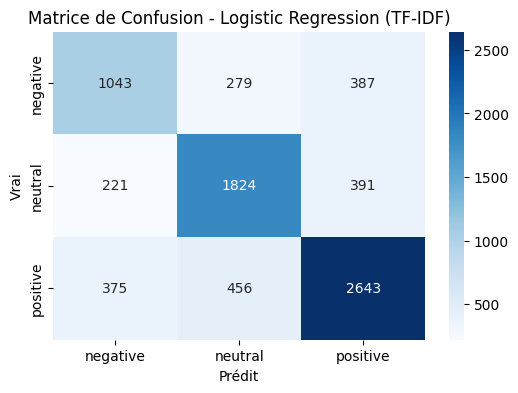

In [23]:
print("--- 4.b. Régression Logistique ---")
# On peut réutiliser le même vectoriseur TF-IDF si les paramètres sont identiques
# ou en créer un spécifique si on veut tester des paramètres différents
tfidf_vectorizer_lr = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf_lr = tfidf_vectorizer_lr.fit_transform(X_train_text)
X_test_tfidf_lr = tfidf_vectorizer_lr.transform(X_test_text)

lr_model = LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear', C=1.0, class_weight='balanced')
# GridSearchCV pour Logistic Regression
# params_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
# grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear', class_weight='balanced'),
#                        params_lr, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_lr.fit(X_train_tfidf_lr, y_train_str)
# lr_model = grid_lr.best_estimator_
# print(f"Meilleurs paramètres pour Régression Logistique: {grid_lr.best_params_}")
lr_model.fit(X_train_tfidf_lr, y_train_str)

y_pred_lr = lr_model.predict(X_test_tfidf_lr)
evaluate_model("Logistic Regression (TF-IDF)", y_test_str, y_pred_lr)

### 4.c. Random Forest avec TF-IDF

Random Forest est un modèle d'ensemble basé sur les arbres de décision, capable de capturer des interactions non linéaires.

--- 4.c. Random Forest avec Meilleurs Hyperparamètres (issus de RandomizedSearch) ---
Entraînement du Random Forest avec les meilleurs hyperparamètres...
Rapport de Classification pour Random Forest (Best Params):
              precision    recall  f1-score   support

    negative       0.54      0.61      0.57      1709
     neutral       0.66      0.69      0.67      2436
    positive       0.76      0.68      0.72      3474

    accuracy                           0.67      7619
   macro avg       0.65      0.66      0.66      7619
weighted avg       0.68      0.67      0.67      7619



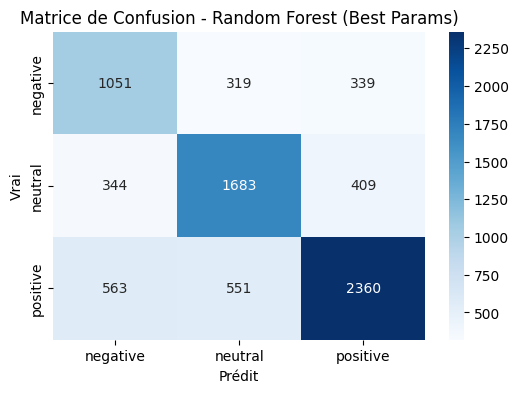

In [24]:
## Cellule Code: Random Forest avec les Meilleurs Hyperparamètres Trouvés

print("--- 4.c. Random Forest avec Meilleurs Hyperparamètres (issus de RandomizedSearch) ---")

# Vectorisation TF-IDF
tfidf_vectorizer_rf_best = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,1))
X_train_tfidf_rf_best = tfidf_vectorizer_rf_best.fit_transform(X_train_text)
X_test_tfidf_rf_best = tfidf_vectorizer_rf_best.transform(X_test_text)

# Meilleurs hyperparamètres trouvés par RandomizedSearchCV 
best_rf_params_found = {
    'bootstrap': False,
    'class_weight': 'balanced',
    'max_depth': None,
    'min_samples_leaf': 8,
    'min_samples_split': 9,
    'n_estimators': 162
}

rf_model_best_params = RandomForestClassifier(
    n_estimators=best_rf_params_found['n_estimators'],
    max_depth=best_rf_params_found['max_depth'],
    min_samples_split=best_rf_params_found['min_samples_split'],
    min_samples_leaf=best_rf_params_found['min_samples_leaf'],
    bootstrap=best_rf_params_found['bootstrap'],
    class_weight=best_rf_params_found['class_weight'],
    random_state=SEED, 
    n_jobs=-1        
)

print("Entraînement du Random Forest avec les meilleurs hyperparamètres...")
rf_model_best_params.fit(X_train_tfidf_rf_best, y_train_str)

# Évaluer le modèle sur le jeu de test
y_pred_rf_best_params = rf_model_best_params.predict(X_test_tfidf_rf_best)
evaluate_model("Random Forest (Best Params)", y_test_str, y_pred_rf_best_params)


## Approche stacking

Rapport de Classification pour Stacking (NB + LR):
              precision    recall  f1-score   support

    negative       0.61      0.68      0.64      1709
     neutral       0.74      0.74      0.74      2436
    positive       0.79      0.75      0.77      3474

    accuracy                           0.73      7619
   macro avg       0.71      0.72      0.72      7619
weighted avg       0.74      0.73      0.73      7619



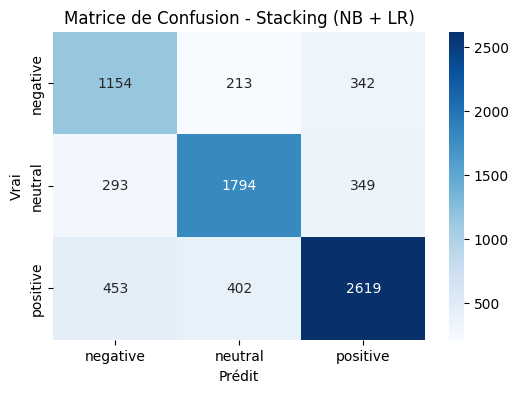

In [45]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Reutilise ton vectorizer TF-IDF
tfidf = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1,2))
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

# Base learners
base_learners = [
    ('nb', MultinomialNB(alpha=3)),
    ('lr', LogisticRegression(max_iter=3000, random_state=SEED, solver='liblinear', C=40.0, class_weight='balanced')),
]

# Meta learner (ici Logistic Regression aussi)
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=3000, class_weight='balanced'),
    cv=20,
    n_jobs=-1
)

# Entraînement
stack_model.fit(X_train, y_train_str)
y_pred_stack = stack_model.predict(X_test)

evaluate_model("Stacking (NB + LR)", y_test_str, y_pred_stack)

## Approche bagging

Rapport de Classification pour Bagging (Voting NB + RF):
              precision    recall  f1-score   support

    negative       0.54      0.73      0.62      1709
     neutral       0.67      0.74      0.70      2436
    positive       0.83      0.63      0.72      3474

    accuracy                           0.69      7619
   macro avg       0.68      0.70      0.68      7619
weighted avg       0.71      0.69      0.69      7619



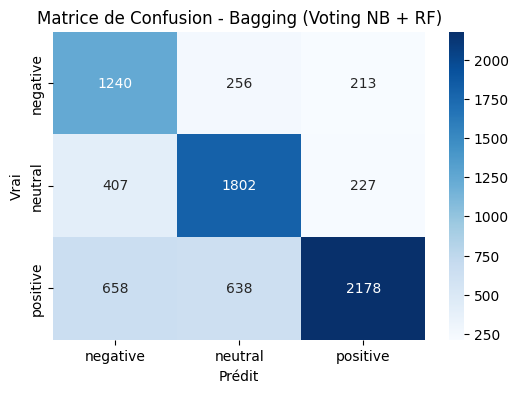

In [47]:
from sklearn.ensemble import VotingClassifier

# Reentraine avec un TF-IDF commun
tfidf = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1,2))
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

voting_model = VotingClassifier(
    estimators=[
        ('nb', MultinomialNB(alpha=0.1)),
        ('rf', RandomForestClassifier(**best_rf_params_found, random_state=SEED, n_jobs=-1))
    ],
    voting='hard'  # vote majoritaire
)

voting_model.fit(X_train, y_train_str)
y_pred_voting = voting_model.predict(X_test)

evaluate_model("Bagging (Voting NB + RF)", y_test_str, y_pred_voting)


## Approche modèle hierachique

Rapport de Classification pour Modèle Hiérarchique (LR + NB):
              precision    recall  f1-score   support

    negative       0.69      0.44      0.54      1709
     neutral       0.67      0.80      0.73      2436
    positive       0.74      0.77      0.75      3474

    accuracy                           0.70      7619
   macro avg       0.70      0.67      0.67      7619
weighted avg       0.70      0.70      0.70      7619



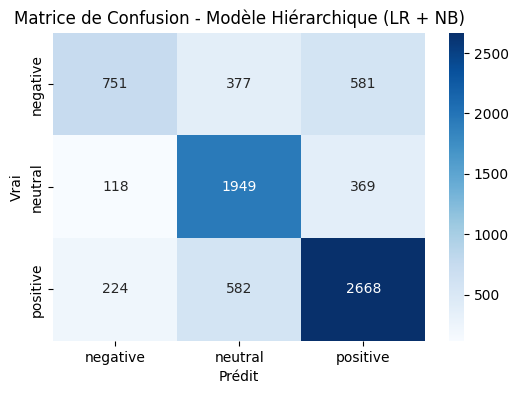

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Vectorisation
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Phase 1 : Neutre vs Non-Neutre
y_train_lvl1 = np.where(y_train_str == 'neutral', 'neutral', 'non-neutral')
y_test_lvl1 = np.where(y_test_str == 'neutral', 'neutral', 'non-neutral')

model_lvl1 = LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')
model_lvl1.fit(X_train_tfidf, y_train_lvl1)

# Phase 2 : Positive vs Negative (seulement sur les "non-neutral")
mask_non_neutral = y_train_str != 'neutral'
X_train_lvl2 = X_train_tfidf[mask_non_neutral]
y_train_lvl2 = y_train_str[mask_non_neutral]

model_lvl2 = MultinomialNB(alpha=0.1)
model_lvl2.fit(X_train_lvl2, y_train_lvl2)

# Prédictions hiérarchiques
pred_lvl1 = model_lvl1.predict(X_test_tfidf)
final_preds = []

for i, pred1 in enumerate(pred_lvl1):
    if pred1 == 'neutral':
        final_preds.append('neutral')
    else:
        pred2 = model_lvl2.predict(X_test_tfidf[i])
        final_preds.append(pred2[0])

evaluate_model("Modèle Hiérarchique (LR + NB)", y_test_str, final_preds)


# 5. Word2Vec + Classifieur

Word2Vec est une technique pour apprendre des représentations vectorielles (embeddings) de mots. Nous allons entraîner un modèle Word2Vec sur nos données d'entraînement, puis utiliser la moyenne des vecteurs des mots d'un tweet comme feature pour un classifieur.

### 5.a. Entraînement du Modèle Word2Vec

In [54]:
print("--- 5.a. Entraînement de Word2Vec ---")
# Tokeniser les textes pour Word2Vec (nltk.word_tokenize est une option simple)
tokenized_X_train_w2v = [word_tokenize(text) for text in X_train_text]
tokenized_X_test_w2v = [word_tokenize(text) for text in X_test_text]

print(f"Exemple de tweet tokenisé: {tokenized_X_train_w2v[0]}")

--- 5.a. Entraînement de Word2Vec ---
Exemple de tweet tokenisé: ['sterling', 'hits', 'a', 'sevenmonth', 'high', 'as', 'election', 'nears', 'economy', 'marketscreener']


In [55]:
W2V_VECTOR_SIZE = 100 # Dimension des embeddings Word2Vec
W2V_WINDOW = 5      # Taille de la fenêtre de contexte
W2V_MIN_COUNT = 2   # Ignorer les mots avec une fréquence totale inférieure à cela
W2V_WORKERS = 4     # Nombre de threads pour l'entraînement

w2v_model = Word2Vec(sentences=tokenized_X_train_w2v,
                     vector_size=W2V_VECTOR_SIZE,
                     window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,
                     workers=W2V_WORKERS,
                     sg=0, # CBOW (0) ou Skip-gram (1)
                     seed=SEED)

print(f"Modèle Word2Vec entraîné. Taille du vocabulaire: {len(w2v_model.wv.index_to_key)}")

# Sauvegarder le modèle (optionnel)
# w2v_model.wv.save_word2vec_format("word2vec_financial_tweets.bin", binary=True)

Modèle Word2Vec entraîné. Taille du vocabulaire: 17466


In [56]:
# Explorer le modèle Word2Vec (si le vocabulaire est assez grand)
try:
    print("\nMots similaires à 'stock' (si dans le vocabulaire):")
    display(w2v_model.wv.most_similar('stock', topn=5))
except KeyError:
    print("'stock' n'est pas dans le vocabulaire du modèle Word2Vec.")

try:
    print("\nMots similaires à 'market' (si dans le vocabulaire):")
    display(w2v_model.wv.most_similar('market', topn=5))
except KeyError:
    print("'market' n'est pas dans le vocabulaire du modèle Word2Vec.")


Mots similaires à 'stock' (si dans le vocabulaire):


[('cap', 0.8520410060882568),
 ('characteristics', 0.831063985824585),
 ('bear', 0.8008905053138733),
 ('economy', 0.7920241951942444),
 ('share', 0.7873196601867676)]


Mots similaires à 'market' (si dans le vocabulaire):


[('splits', 0.8589823246002197),
 ('backbone', 0.8446412682533264),
 ('chatrooms', 0.8377217054367065),
 ('performing', 0.822654664516449),
 ('split', 0.8132709860801697)]

### 5.b. Création des Vecteurs de Document et Classification

Nous moyennons les vecteurs Word2Vec des mots de chaque tweet pour obtenir un vecteur de document unique.

In [57]:
def document_vector(doc_tokens, model, num_features):
    # Filtrer les mots hors vocabulaire
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    index2word_set = set(model.wv.index_to_key) # Pour une recherche plus rapide

    for word in doc_tokens:
        if word in index2word_set:
            num_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

In [58]:
X_train_w2v = np.array([document_vector(doc, w2v_model, W2V_VECTOR_SIZE) for doc in tokenized_X_train_w2v])
X_test_w2v = np.array([document_vector(doc, w2v_model, W2V_VECTOR_SIZE) for doc in tokenized_X_test_w2v])

print(f"Shape de X_train_w2v: {X_train_w2v.shape}")
print(f"Shape de X_test_w2v: {X_test_w2v.shape}")

Shape de X_train_w2v: (30472, 100)
Shape de X_test_w2v: (7619, 100)


Rapport de Classification pour Logistic Regression (Word2Vec Avg):
              precision    recall  f1-score   support

    negative       0.40      0.33      0.36      1709
     neutral       0.56      0.67      0.61      2436
    positive       0.65      0.62      0.64      3474

    accuracy                           0.57      7619
   macro avg       0.54      0.54      0.54      7619
weighted avg       0.57      0.57      0.57      7619



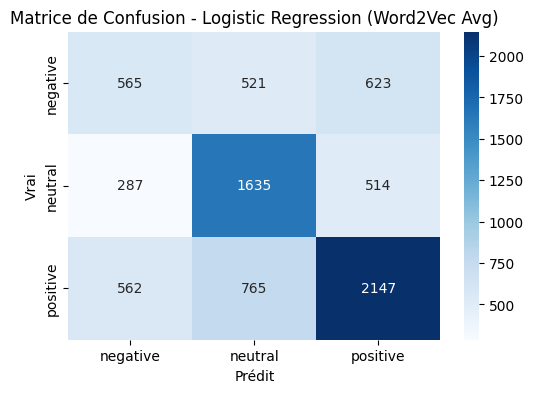

In [59]:
# Utiliser Word2Vec avec une Régression Logistique
lr_w2v_model = LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear', C=1.0, class_weight='balanced')
lr_w2v_model.fit(X_train_w2v, y_train_str)

y_pred_lr_w2v = lr_w2v_model.predict(X_test_w2v)
evaluate_model("Logistic Regression (Word2Vec Avg)", y_test_str, y_pred_lr_w2v)

# 6. Réseaux de Neurones avec Keras/TensorFlow

Nous allons maintenant explorer des modèles plus complexes basés sur les réseaux de neurones.

In [60]:
# y_train_encoded et y_test_encoded ont été créés lors du split initial.
# y_train_int et y_test_int sont les labels originaux 0,1,2.
# Pour Keras, nous avons besoin de labels one-hot encodés.

num_classes = len(label_encoder_global.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"Shape de y_train_categorical: {y_train_categorical.shape}")
print(f"Exemple de label one-hot: {y_train_categorical[0]} (correspond à '{y_train_str.iloc[0]}')")

Shape de y_train_categorical: (30472, 3)
Exemple de label one-hot: [0. 0. 1.] (correspond à 'positive')


### 6.a. Réseau Feedforward (MLP) avec TF-IDF

Un Perceptron Multi-Couches (MLP) simple utilisant les features TF-IDF.

In [61]:
print("--- 6.a. Réseau Feedforward (MLP) avec TF-IDF ---")
# Utiliser les mêmes Tfidf que pour LR/NB pour la comparaison, ou en créer un nouveau
# Nous réutilisons X_train_tfidf_lr et X_test_tfidf_lr (issus du TfidfVectorizer pour la LR)
X_train_tfidf_dense_mlp = X_train_tfidf_lr.toarray() # Keras MLP préfère les matrices denses
X_test_tfidf_dense_mlp = X_test_tfidf_lr.toarray()

print(f"Shape de X_train_tfidf_dense_mlp: {X_train_tfidf_dense_mlp.shape}")

--- 6.a. Réseau Feedforward (MLP) avec TF-IDF ---
Shape de X_train_tfidf_dense_mlp: (30472, 5000)


/home/wassim/repos/nlp/projet/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,579 (2.47 MB)

 Trainable params: 648,579 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-05-09 22:26:41.529396: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 548480000 exceeds 10% of free system memory.


857/857 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5663 - loss: 0.9042 - val_accuracy: 0.7093 - val_loss: 0.6658
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7501 - loss: 0.6115 - val_accuracy: 0.7175 - val_loss: 0.6703
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7967 - loss: 0.5122 - val_accuracy: 0.7188 - val_loss: 0.6996
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8331 - loss: 0.4349 - val_accuracy: 0.7215 - val_loss: 0.7595


2025-05-09 22:26:54.285828: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 152380000 exceeds 10% of free system memory.


239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
Rapport de Classification pour MLP (TF-IDF):
              precision    recall  f1-score   support

    negative       0.65      0.56      0.60      1709
     neutral       0.72      0.73      0.73      2436
    positive       0.74      0.79      0.76      3474

    accuracy                           0.72      7619
   macro avg       0.70      0.69      0.70      7619
weighted avg       0.71      0.72      0.71      7619



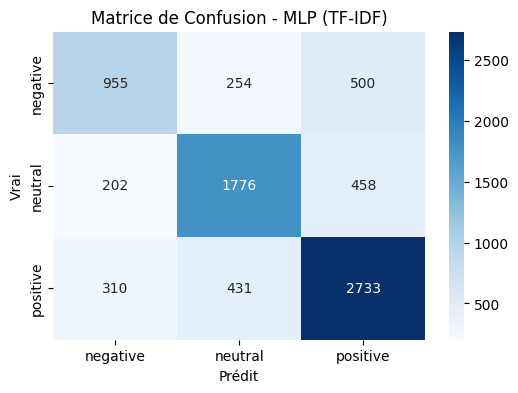

In [62]:
MLP_EPOCHS = 10 # Augmenter pour de meilleurs résultats, mais attention au surapprentissage
MLP_BATCH_SIZE = 32

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf_dense_mlp.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
mlp_model.summary()

early_stopping_mlp = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mlp = mlp_model.fit(X_train_tfidf_dense_mlp, y_train_categorical,
                            epochs=MLP_EPOCHS,
                            batch_size=MLP_BATCH_SIZE,
                            validation_split=0.1, # Utilise 10% des données d'entraînement pour la validation
                            callbacks=[early_stopping_mlp],
                            verbose=1)

loss_mlp, acc_mlp = mlp_model.evaluate(X_test_tfidf_dense_mlp, y_test_categorical, verbose=0)
y_pred_mlp_probs = mlp_model.predict(X_test_tfidf_dense_mlp)
y_pred_mlp_encoded = np.argmax(y_pred_mlp_probs, axis=1)
y_pred_mlp_str = label_encoder_global.inverse_transform(y_pred_mlp_encoded)

evaluate_model("MLP (TF-IDF)", y_test_str, y_pred_mlp_str)
# Remplacer la valeur d'accuracy par celle obtenue sur le test set si EarlyStopping est utilisé
results_summary["MLP (TF-IDF)"]['accuracy'] = acc_mlp

### 6.b. Réseau Récurrent (LSTM) avec Embeddings

Les LSTM (Long Short-Term Memory) sont bien adaptés au traitement de séquences comme le texte. Nous utiliserons une couche d'embedding apprise conjointement avec le modèle.

In [63]:
print("--- 6.b. Réseau Récurrent (LSTM) ---")
NN_MAX_WORDS = 15000      # Nombre max de mots à garder dans le vocabulaire du Tokenizer Keras
NN_MAX_SEQUENCE_LENGTH = 100 # Longueur max des séquences (tweets)
NN_EMBEDDING_DIM = 100    # Dimension de la couche d'embedding (peut être la même que W2V_VECTOR_SIZE)
LSTM_EPOCHS = 5           # Peut nécessiter plus d'époques, mais attention au temps
LSTM_BATCH_SIZE = 64

--- 6.b. Réseau Récurrent (LSTM) ---


In [64]:
keras_tokenizer = KerasTokenizer(num_words=NN_MAX_WORDS, oov_token="<unk>") # <unk> pour les mots inconnus
keras_tokenizer.fit_on_texts(X_train_text)

X_train_sequences = keras_tokenizer.texts_to_sequences(X_train_text)
X_test_sequences = keras_tokenizer.texts_to_sequences(X_test_text)

X_train_padded = pad_sequences(X_train_sequences, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

word_index_keras = keras_tokenizer.word_index
print(f"Vocabulaire du Tokenizer Keras contient {len(word_index_keras)} mots uniques.")
print(f"Shape de X_train_padded: {X_train_padded.shape}")

Vocabulaire du Tokenizer Keras contient 40361 mots uniques.
Shape de X_train_padded: (30472, 100)


In [65]:
# Optionnel : Utiliser les embeddings Word2Vec pré-entraînés comme poids initiaux pour la couche Embedding
# Cela peut aider si le dataset d'entraînement est petit.

embedding_matrix_lstm = np.zeros((min(NN_MAX_WORDS, len(word_index_keras) + 1), NN_EMBEDDING_DIM))
num_w2v_loaded = 0
for word, i in word_index_keras.items():
    if i >= NN_MAX_WORDS:
        continue
    if word in w2v_model.wv: # Utiliser le w2v_model entraîné précédemment
        embedding_vector = w2v_model.wv[word]
        embedding_matrix_lstm[i] = embedding_vector
        num_w2v_loaded +=1

print(f"{num_w2v_loaded} vecteurs de mots chargés depuis Word2Vec dans la matrice d'embedding LSTM.")

# Si True, les poids de la couche Embedding seront figés (ceux de Word2Vec).
# Si False, ils seront fine-tunés pendant l'entraînement du LSTM.
USE_PRETRAINED_W2V_FOR_LSTM = True
TRAINABLE_EMBEDDING_LSTM = not USE_PRETRAINED_W2V_FOR_LSTM if USE_PRETRAINED_W2V_FOR_LSTM else True

14847 vecteurs de mots chargés depuis Word2Vec dans la matrice d'embedding LSTM.


--- 6.b. Réseau Récurrent (LSTM) - AMÉLIORÉ avec Word2Vec ---
Tokenisation des textes pour le LSTM avec Word2Vec...
Vocabulaire du Tokenizer Keras (pour W2V LSTM) contient 40361 mots uniques.
Shape de X_train_padded (pour W2V LSTM): (30472, 100)
Création de la matrice d'embedding à partir de votre modèle Word2Vec...
14847 vecteurs de mots chargés depuis VOTRE Word2Vec dans la matrice d'embedding LSTM.
Calcul des poids des classes pour la fonction de perte...
Poids des classes calculés (pour W2V LSTM): {0: 1.4865115371481536, 1: 1.0423122969043954, 2: 0.73105897029893}
Définition de l'architecture du modèle LSTM amélioré...
Résumé du modèle LSTM amélioré:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_embedding (Embedding)      │ (None, 100, 100)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 100, 256)       │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_intermediate (Dense)      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,907,299 (7.28 MB)

 Trainable params: 1,907,299 (7.28 MB)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement du modèle LSTM amélioré avec Word2Vec...
Epoch 1/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - accuracy: 0.4592 - loss: 1.0941 - val_accuracy: 0.5636 - val_loss: 0.8911 - learning_rate: 0.0010
Epoch 2/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 76s 177ms/step - accuracy: 0.6008 - loss: 0.8679 - val_accuracy: 0.6906 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 3/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 73s 170ms/step - accuracy: 0.7441 - loss: 0.6329 - val_accuracy: 0.7028 - val_loss: 0.7731 - learning_rate: 0.0010
Epoch 4/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8210 - loss: 0.4637
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
429/429 ━━━━━━━━━━━━━━━━━━━━ 73s 170ms/step - accuracy: 0.8210 - loss: 0.4636 - val_accuracy: 0.7182 - val_loss: 0.8257 - learning_rate: 0.0010
Epoch 5/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 73s 170ms/step - accuracy: 0.8716 - loss: 0.3584 - val_accuracy: 0.7283 - val_loss: 0.9034 - learning_rate: 2.0000e-04
Ep

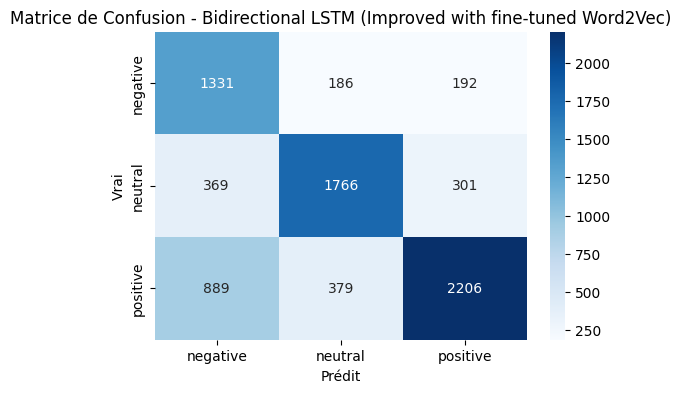

Analyse du LSTM amélioré avec Word2Vec terminée.


In [66]:
print("--- 6.b. Réseau Récurrent (LSTM) - AMÉLIORÉ avec Word2Vec ---")

# --- Paramètres Configurables ---
# Ces paramètres sont essentiels pour la performance et la reproductibilité.
# NN_MAX_WORDS: Taille maximale du vocabulaire à considérer par le Tokenizer Keras.
# NN_MAX_SEQUENCE_LENGTH: Longueur à laquelle toutes les séquences de mots (tweets) seront paddées ou tronquées.
# NN_EMBEDDING_DIM: Dimension des vecteurs d'embedding (doit correspondre à la dimension de vos embeddings Word2Vec).
# LSTM_EPOCHS_IMPROVED_W2V: Nombre maximal d'époques pour l'entraînement. EarlyStopping peut l'arrêter plus tôt.
# LSTM_BATCH_SIZE_IMPROVED_W2V: Nombre d'échantillons par mise à jour des poids du gradient.
# LSTM_LEARNING_RATE_W2V: Taux d'apprentissage initial pour l'optimiseur Adam.

# Assurez-vous que ces constantes sont définies à partir de vos étapes précédentes.
# Exemple de valeurs typiques (adaptez si vos variables ont d'autres noms ou valeurs):
# NN_MAX_WORDS = 15000 (valeur utilisée précédemment pour Keras Tokenizer)
# NN_MAX_SEQUENCE_LENGTH = 100 (valeur utilisée précédemment pour le padding)
# NN_EMBEDDING_DIM = 100 (si W2V_VECTOR_SIZE était 100)

LSTM_EPOCHS_IMPROVED_W2V = 15
LSTM_BATCH_SIZE_IMPROVED_W2V = 64
LSTM_LEARNING_RATE_W2V = 0.001

# --- Vérification des variables prérequises ---
# Ce code suppose que les variables suivantes sont déjà définies et chargées
# à partir des étapes précédentes de votre notebook :
# - X_train_text, X_test_text: Textes nettoyés pour l'entraînement et le test.
# - y_train_encoded, y_test_encoded: Labels encodés numériquement (ex: 0, 1, 2) pour l'entraînement et le test.
# - y_train_categorical, y_test_categorical: Labels one-hot encodés pour l'entraînement et le test.
# - label_encoder_global: L'instance de LabelEncoder fittée sur vos labels string.
# - num_classes: Le nombre de classes de sentiment uniques.
# - w2v_model: Votre modèle Gensim Word2Vec entraîné.
# - SEED: La graine aléatoire pour la reproductibilité.

# --- Tokenisation Keras (si non déjà faite ou pour s'assurer de la cohérence) ---
# Si X_train_padded, X_test_padded, word_index_keras sont déjà définis avec les bons paramètres,
# vous pouvez sauter cette re-tokenisation. Sinon, il est crucial de la refaire ici
# pour s'assurer que le word_index correspond à embedding_matrix_lstm.

print("Tokenisation des textes pour le LSTM avec Word2Vec...")
keras_tokenizer_w2v_imp = KerasTokenizer(num_words=NN_MAX_WORDS, oov_token="<unk>") # oov_token gère les mots hors vocabulaire
keras_tokenizer_w2v_imp.fit_on_texts(X_train_text)
word_index_keras = keras_tokenizer_w2v_imp.word_index # Remplacer l'ancien word_index si vous re-tokenisez

X_train_sequences_w2v_imp = keras_tokenizer_w2v_imp.texts_to_sequences(X_train_text)
X_test_sequences_w2v_imp = keras_tokenizer_w2v_imp.texts_to_sequences(X_test_text)

# Remplacer X_train_padded et X_test_padded par les nouvelles séquences paddées
X_train_padded = pad_sequences(X_train_sequences_w2v_imp, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences_w2v_imp, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulaire du Tokenizer Keras (pour W2V LSTM) contient {len(word_index_keras)} mots uniques.")
print(f"Shape de X_train_padded (pour W2V LSTM): {X_train_padded.shape}")


# --- Création de la Matrice d'Embedding Word2Vec ---
# Cette matrice sert à initialiser les poids de la couche Embedding du LSTM.
# Elle mappe les indices de mots du Tokenizer Keras aux vecteurs de votre modèle Word2Vec.
print("Création de la matrice d'embedding à partir de votre modèle Word2Vec...")
embedding_matrix_lstm = np.zeros((min(NN_MAX_WORDS, len(word_index_keras) + 1), NN_EMBEDDING_DIM))
num_w2v_loaded_in_matrix = 0
for word, i in word_index_keras.items():
    if i >= NN_MAX_WORDS: # Ne considérer que les mots dans la limite du vocabulaire du Tokenizer
        continue
    if word in w2v_model.wv: # Vérifier si le mot existe dans le vocabulaire Word2Vec
        embedding_vector = w2v_model.wv[word]
        embedding_matrix_lstm[i] = embedding_vector # Assigner le vecteur
        num_w2v_loaded_in_matrix +=1
print(f"{num_w2v_loaded_in_matrix} vecteurs de mots chargés depuis VOTRE Word2Vec dans la matrice d'embedding LSTM.")


# --- Calcul des Poids des Classes ---
# Utile pour les datasets déséquilibrés. Cela donne plus de poids dans la fonction de perte
# aux erreurs faites sur les classes minoritaires.
print("Calcul des poids des classes pour la fonction de perte...")
class_weights_values_w2v = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded), # Utilise les labels encodés numériquement
    y=y_train_encoded
)
class_weights_dict_w2v = dict(enumerate(class_weights_values_w2v))
print(f"Poids des classes calculés (pour W2V LSTM): {class_weights_dict_w2v}")


# --- Définition du Modèle LSTM Amélioré avec vos Word2Vec ---
print("Définition de l'architecture du modèle LSTM amélioré...")
lstm_model_improved_w2v = Sequential([
    # Couche d'Input explicite (bonne pratique, aide Keras à construire le modèle tôt)
    Input(shape=(NN_MAX_SEQUENCE_LENGTH,), name="input_sequence"),

    # Couche d'Embedding
    # input_dim: Taille du vocabulaire (+1 pour le padding/OOV si l'indice 0 est utilisé).
    # output_dim: Dimension des vecteurs d'embedding.
    # weights: Initialise les poids avec la matrice Word2Vec pré-calculée.
    # trainable=True: TRÈS IMPORTANT! Permet au réseau d'ajuster (fine-tuner) ces embeddings
    #                 Word2Vec pendant l'entraînement pour les adapter à la tâche spécifique.
    Embedding(input_dim=min(NN_MAX_WORDS, len(word_index_keras) + 1),
              output_dim=NN_EMBEDDING_DIM,
              weights=[embedding_matrix_lstm],
              trainable=True, # Fine-tuning des embeddings Word2Vec
              name="word_embedding"
              ),

    # Couches LSTM Bidirectionnelles
    # Bidirectional permet au LSTM de traiter la séquence dans les deux sens (passé et futur).
    # units: Dimension de l'espace de sortie (et de l'état interne).
    # dropout: Taux de dropout pour les connexions linéaires d'entrée.
    # recurrent_dropout: Taux de dropout pour les connexions récurrentes (états).
    # return_sequences=True: Nécessaire si la couche LSTM suivante attend une séquence en entrée.
    Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.4, return_sequences=True), name="bidirectional_lstm_1"),
    Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4), name="bidirectional_lstm_2"), # La dernière couche LSTM ne retourne pas de séquence

    # Couche Dense intermédiaire
    # kernel_regularizer: Ajoute une pénalité L2 aux poids pour réduire le surapprentissage.
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name="dense_intermediate"),
    Dropout(0.5, name="dropout_final"), # Dropout avant la couche de sortie

    # Couche de Sortie
    # units: Nombre de classes de sortie.
    # activation='softmax': Pour la classification multi-classe, produit une distribution de probabilité.
    Dense(num_classes, activation='softmax', name="output_softmax")
])

# --- Compilation du Modèle ---
# optimizer: Algorithme pour mettre à jour les poids (Adam est un choix courant).
# loss: Fonction à minimiser (categorical_crossentropy pour la classification multi-classe avec labels one-hot).
# metrics: Métriques à suivre pendant l'entraînement.
optimizer_lstm_w2v = tf.keras.optimizers.Adam(learning_rate=LSTM_LEARNING_RATE_W2V)
lstm_model_improved_w2v.compile(optimizer=optimizer_lstm_w2v,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# --- Affichage du Résumé du Modèle ---
# Maintenant que la couche Input est définie, le summary devrait être complet.
print("Résumé du modèle LSTM amélioré:")
lstm_model_improved_w2v.summary()

# --- Callbacks pour l'Entraînement ---
# EarlyStopping: Arrête l'entraînement si une métrique monitorée (val_loss) ne s'améliore plus
#                après un certain nombre d'époques (patience). Restore_best_weights garde les
#                meilleurs poids trouvés.
# ReduceLROnPlateau: Réduit le taux d'apprentissage si la métrique monitorée stagne.
#                    Cela peut aider le modèle à converger vers un meilleur minimum.
early_stopping_lstm_imp_w2v = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr_lstm_imp_w2v = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1) # min_lr ajusté

# --- Entraînement du Modèle ---
print("Début de l'entraînement du modèle LSTM amélioré avec Word2Vec...")
history_lstm_improved_w2v = lstm_model_improved_w2v.fit(
    X_train_padded,       # Données d'entraînement paddées
    y_train_categorical,  # Labels d'entraînement one-hot encodés
    epochs=LSTM_EPOCHS_IMPROVED_W2V,
    batch_size=LSTM_BATCH_SIZE_IMPROVED_W2V,
    validation_split=0.1, # Utilise 10% des données d'entraînement pour la validation pendant l'entraînement
    callbacks=[early_stopping_lstm_imp_w2v, reduce_lr_lstm_imp_w2v],
    class_weight=class_weights_dict_w2v, # Appliquer les poids des classes pour gérer le déséquilibre
    verbose=1 # Afficher la progression de l'entraînement
)

# --- Évaluation du Modèle sur le Jeu de Test ---
print("Évaluation du modèle LSTM amélioré sur le jeu de test...")
loss_lstm_imp_w2v, acc_lstm_imp_w2v = lstm_model_improved_w2v.evaluate(
    X_test_padded,        # Données de test paddées
    y_test_categorical,   # Labels de test one-hot encodés
    verbose=0 # Pas besoin d'afficher la progression ici
)

# --- Prédictions et Rapport de Classification ---
print("Génération des prédictions et du rapport de classification...")
y_pred_lstm_probs_imp_w2v = lstm_model_improved_w2v.predict(X_test_padded)
y_pred_lstm_encoded_imp_w2v = np.argmax(y_pred_lstm_probs_imp_w2v, axis=1) # Convertir probabilités en classes prédites (encodées)
y_pred_lstm_str_imp_w2v = label_encoder_global.inverse_transform(y_pred_lstm_encoded_imp_w2v) # Reconvertir en labels string

# Utiliser votre fonction evaluate_model pour afficher le rapport et la matrice de confusion
evaluate_model("Bidirectional LSTM (Improved with fine-tuned Word2Vec)", y_test_str, y_pred_lstm_str_imp_w2v)

# Mise à jour du dictionnaire des résultats
results_summary["Bidirectional LSTM (Improved with fine-tuned Word2Vec)"] = {
    'accuracy': acc_lstm_imp_w2v,
    'precision_macro': classification_report(y_test_str, y_pred_lstm_str_imp_w2v, output_dict=True, zero_division=0)['macro avg']['precision'],
    'recall_macro': classification_report(y_test_str, y_pred_lstm_str_imp_w2v, output_dict=True, zero_division=0)['macro avg']['recall'],
    'f1_macro': classification_report(y_test_str, y_pred_lstm_str_imp_w2v, output_dict=True, zero_division=0)['macro avg']['f1-score']
}

print("Analyse du LSTM amélioré avec Word2Vec terminée.")

# 7. Transformers avec Hugging Face

Les modèles Transformers sont l'état de l'art pour de nombreuses tâches NLP. Nous allons fine-tuner un modèle pré-entraîné (comme DistilBERT ou FinBERT) sur notre dataset.
Attention : Cette partie est gourmande en ressources et peut être longue à exécuter, surtout sans GPU. Un GPU est fortement recommandé.

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device} pour Transformers")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Utilisation du device: cpu pour Transformers


In [68]:
print("--- 7. Transformers (Fine-tuning) ---")

# Utiliser les labels entiers (0,1,2...) pour les Transformers.
# y_train_int et y_test_int contiennent déjà ces labels.
# La bibliothèque `datasets` attend une colonne nommée 'label'.
train_df_hf = pd.DataFrame({'text': X_train_text.copy(), 'label': y_train_int.copy()})
test_df_hf = pd.DataFrame({'text': X_test_text.copy(), 'label': y_test_int.copy()})

# Optionnel : Sous-échantillonner pour des tests rapides sur CPU
# SAMPLE_SIZE_HF_TRAIN = 1000 # ou plus si vous avez de la patience/GPU
# SAMPLE_SIZE_HF_TEST = 200
# if len(train_df_hf) > SAMPLE_SIZE_HF_TRAIN:
#     train_df_hf = train_df_hf.sample(n=SAMPLE_SIZE_HF_TRAIN, random_state=SEED)
# if len(test_df_hf) > SAMPLE_SIZE_HF_TEST:
#     test_df_hf = test_df_hf.sample(n=SAMPLE_SIZE_HF_TEST, random_state=SEED)

train_dataset_hf = Dataset.from_pandas(train_df_hf)
test_dataset_hf = Dataset.from_pandas(test_df_hf)

print(f"Dataset d'entraînement Hugging Face: {train_dataset_hf}")
print(f"Dataset de test Hugging Face: {test_dataset_hf}")

--- 7. Transformers (Fine-tuning) ---
Dataset d'entraînement Hugging Face: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 30472
})
Dataset de test Hugging Face: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 7619
})


In [69]:
# Modèles possibles:
# - 'distilbert-base-uncased': Léger, rapide, bon pour l'anglais général.
# - 'ProsusAI/finbert': Spécialisé pour les textes financiers en anglais. (Peut être plus lourd)
# - 'nlptown/bert-base-multilingual-uncased-sentiment': Si les tweets sont multilingues et pour du sentiment, mais moins spécifique que FinBERT.
MODEL_NAME_HF = 'distilbert-base-uncased'
# MODEL_NAME_HF = 'ProsusAI/finbert' # Décommentez pour essayer FinBERT

try:
    tokenizer_hf = AutoTokenizer.from_pretrained(MODEL_NAME_HF)
    # Pour num_labels, s'assurer que c'est bien le nombre de classes uniques dans y_train_int
    model_hf = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_HF, num_labels=len(np.unique(y_train_int)))
    model_hf.to(device) # Déplacer le modèle sur le GPU si disponible
except Exception as e:
    print(f"Erreur lors du chargement du modèle/tokenizer Transformer {MODEL_NAME_HF}: {e}")
    print("Vérifiez le nom du modèle et votre connexion internet.")
    model_hf = None # Pour éviter les erreurs plus loin

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
def tokenize_function_hf(examples):
    # Truncation et padding seront gérés par le DataCollator par défaut
    # Mais on peut spécifier max_length pour le tokenizer aussi
    return tokenizer_hf(examples["text"], truncation=True, padding=False, max_length=128) # max_length est un hyperparamètre

if model_hf: # Continuer seulement si le modèle a été chargé
    train_tokenized_dataset_hf = train_dataset_hf.map(tokenize_function_hf, batched=True)
    test_tokenized_dataset_hf = test_dataset_hf.map(tokenize_function_hf, batched=True)

    # Supprimer la colonne 'text' car le modèle n'en a plus besoin après tokenisation
    # et __index_level_0__ si elle a été ajoutée par from_pandas
    train_tokenized_dataset_hf = train_tokenized_dataset_hf.remove_columns(
        [col for col in train_tokenized_dataset_hf.column_names if col not in ['input_ids', 'attention_mask', 'label']]
    )
    test_tokenized_dataset_hf = test_tokenized_dataset_hf.remove_columns(
        [col for col in test_tokenized_dataset_hf.column_names if col not in ['input_ids', 'attention_mask', 'label']]
    )
    print("\nDatasets tokenisés prêts.")
else:
    print("Le modèle Transformer n'a pas été chargé, la suite de cette section est sautée.")

Map:   0%|          | 0/30472 [00:00<?, ? examples/s]

Map:   0%|          | 0/7619 [00:00<?, ? examples/s]


Datasets tokenisés prêts.


In [71]:
# Charger les métriques avec la nouvelle API evaluate
accuracy_metric_hf = evaluate.load("accuracy")
f1_metric_hf = evaluate.load("f1")

def compute_metrics_hf(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc_results = accuracy_metric_hf.compute(predictions=predictions, references=labels)
    f1_results = f1_metric_hf.compute(predictions=predictions, references=labels, average="macro") # 'macro' est souvent un bon choix pour la classification multi-classe
    
    return {
        "accuracy": acc_results["accuracy"],
        "f1_macro": f1_results["f1"]
    }

In [72]:
HF_EPOCHS = 1 # Commencer avec 1-2 époques pour un test rapide, augmenter à 3-5 pour de meilleurs résultats.
HF_BATCH_SIZE_TRAIN = 16 # Ajuster selon la mémoire GPU (8, 16, 32)
HF_BATCH_SIZE_EVAL = HF_BATCH_SIZE_TRAIN * 2 # Peut être plus grand pour l'évaluation

if model_hf:
    training_args = TrainingArguments(
        output_dir=f"./results_hf_{MODEL_NAME_HF.split('/')[-1]}",
        num_train_epochs=HF_EPOCHS,
        per_device_train_batch_size=HF_BATCH_SIZE_TRAIN,
        per_device_eval_batch_size=HF_BATCH_SIZE_EVAL,
        warmup_ratio=0.1, # warmup_steps = int(len(train_tokenized_dataset_hf) * HF_EPOCHS * 0.1 / HF_BATCH_SIZE_TRAIN)
        weight_decay=0.01,
        logging_dir=f'./logs_hf_{MODEL_NAME_HF.split('/')[-1]}',
        logging_strategy="steps",
        logging_steps=max(1, int(len(train_tokenized_dataset_hf) / (HF_BATCH_SIZE_TRAIN * 4) )), # Log ~4 fois par époque
        eval_strategy="epoch",
        save_strategy="epoch", # Sauvegarde le meilleur modèle à la fin de chaque époque
        load_best_model_at_end=True, # Charge le meilleur modèle à la fin de l'entraînement
        metric_for_best_model="f1_macro", # Choisir la métrique pour sélectionner le "meilleur" modèle
        greater_is_better=True,
        report_to="none", # "tensorboard", "wandb" si configuré, "none" pour désactiver
        # fp16=torch.cuda.is_available(), # Active le mixed-precision training si GPU et CUDA (peut accélérer et réduire la mémoire)
        seed=SEED,
        disable_tqdm=False # Mettre à True si les barres de progression sont gênantes
    )

In [73]:
if model_hf:
    trainer = Trainer(
        model=model_hf,
        args=training_args,
        train_dataset=train_tokenized_dataset_hf,
        eval_dataset=test_tokenized_dataset_hf, # Idéalement, un vrai jeu de validation séparé ici
        compute_metrics=compute_metrics_hf,
        processing_class=tokenizer_hf # Le DataCollator utilisera le padding du tokenizer
    )

In [74]:
if model_hf:
    print(f"Entraînement du Transformer {MODEL_NAME_HF} (peut être long)...")
    try:
        train_result = trainer.train()
        print("\nEntraînement terminé.")
        # Sauvegarder le meilleur modèle et le tokenizer
        trainer.save_model(f"./best_model_{MODEL_NAME_HF.split('/')[-1]}")
        tokenizer_hf.save_pretrained(f"./best_model_{MODEL_NAME_HF.split('/')[-1]}")
    except Exception as e:
        print(f"Erreur pendant l'entraînement du Transformer: {e}")
        train_result = None # Indiquer que l'entraînement a échoué
else:
    print("Entraînement du Transformer sauté car le modèle n'a pas été chargé.")
    train_result = None

Entraînement du Transformer distilbert-base-uncased (peut être long)...


/home/wassim/repos/nlp/projet/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.510000,0.482127,0.804043,0.792608



Entraînement terminé.



Évaluation du Transformer distilbert-base-uncased sur le jeu de test...


/home/wassim/repos/nlp/projet/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Résultats de l'évaluation: {'eval_loss': 0.48212730884552, 'eval_accuracy': 0.8040425252657829, 'eval_f1_macro': 0.7926083430690986, 'eval_runtime': 115.2077, 'eval_samples_per_second': 66.133, 'eval_steps_per_second': 2.075, 'epoch': 1.0}

Prédictions sur le jeu de test...


/home/wassim/repos/nlp/projet/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Rapport de Classification pour Transformer (distilbert-base-uncased):
              precision    recall  f1-score   support

    negative       0.07      0.10      0.09      1709
     neutral       0.09      0.13      0.10      2436
    positive       0.15      0.07      0.09      3474

    accuracy                           0.10      7619
   macro avg       0.10      0.10      0.09      7619
weighted avg       0.11      0.10      0.10      7619



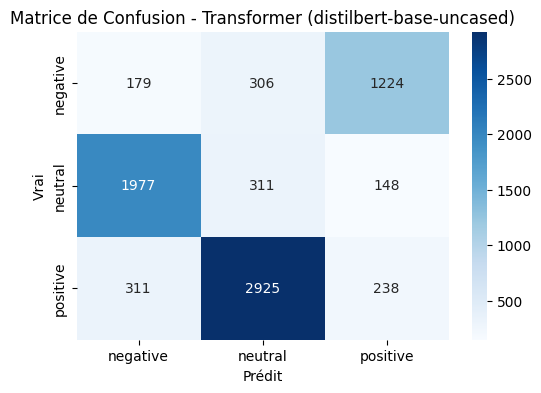

In [75]:
acc_transformer = 0.0 # Valeur par défaut
if model_hf and train_result: # S'assurer que l'entraînement a eu lieu
    print(f"\nÉvaluation du Transformer {MODEL_NAME_HF} sur le jeu de test...")
    eval_results = trainer.evaluate(test_tokenized_dataset_hf)
    print(f"Résultats de l'évaluation: {eval_results}")
    acc_transformer = eval_results.get('eval_accuracy', 0.0) # Utiliser .get pour éviter KeyError
    f1_transformer = eval_results.get('eval_f1_macro', 0.0)

    print("\nPrédictions sur le jeu de test...")
    predictions_hf_output = trainer.predict(test_tokenized_dataset_hf)
    y_pred_hf_logits = predictions_hf_output.predictions
    y_pred_hf_int = np.argmax(y_pred_hf_logits, axis=1)
    # Reconvertir les prédictions (int) en labels string pour classification_report
    # S'assurer que label_encoder_global a été fitté sur les labels string 'negative', 'neutral', 'positive'
    # Et que y_pred_hf_int correspond bien aux indices de ces classes
    # Vérifier l'ordre des classes dans label_encoder_global.classes_ et l'ordre de sortie du modèle
    # Normalement, si y_train_int (0,1,2) a été utilisé pour l'entraînement, et que model_hf.config.id2label
    # est correctement mappé (ou par défaut 0->LABEL_0, 1->LABEL_1, etc.), cela devrait fonctionner.
    # Il faut s'assurer que l'entier 0 prédit par le transformer correspond bien à la classe
    # que label_encoder_global.inverse_transform([0]) donnerait.
    # Si le mapping des labels dans le transformer est {0: "neutral", 1: "positive", 2: "negative"}
    # et label_encoder_global.classes_ est ['negative', 'neutral', 'positive']
    # alors il faut remapper y_pred_hf_int.

    # Hypothèse : le modèle Transformer sort les classes dans l'ordre 0, 1, 2
    # et label_encoder_global.classes_ est ['negative', 'neutral', 'positive']
    # et map_labels_str = {0: "neutral", 1: 'positive',  2: 'negative'}
    # Il faut donc un mapping.

    # Solution plus simple : utiliser le mapping du config du modèle si disponible
    id2label_hf = model_hf.config.id2label if hasattr(model_hf.config, 'id2label') else \
                  {i: f"LABEL_{i}" for i in range(model_hf.config.num_labels)}
    
    # Si id2label_hf est {0: "neutral", 1: "positive", 2: "negative"}
    # et que vos y_test_str sont dans cet ordre, c'est bon.
    # Sinon, il faut aligner.
    # Pour l'instant, supposons que y_pred_hf_int sont les indices pour label_encoder_global
    try:
        y_pred_hf_str = label_encoder_global.inverse_transform(y_pred_hf_int)
        evaluate_model(f"Transformer ({MODEL_NAME_HF.split('/')[-1]})", y_test_str, y_pred_hf_str)
        # Mettre à jour results_summary avec les métriques de compute_metrics_hf
        results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"]['accuracy'] = acc_transformer
        results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"]['f1_macro'] = f1_transformer

    except Exception as e:
        print(f"Erreur lors de la reconversion des labels Transformer ou de l'évaluation: {e}")
        # Fallback si la reconversion échoue
        results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"] = {
            'accuracy': acc_transformer, 'precision_macro': 0, 'recall_macro': 0, 'f1_macro': 0
        }

elif model_hf and not train_result:
    print("L'entraînement du Transformer a échoué ou a été sauté, pas d'évaluation.")
    results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"] = {
        'accuracy': 0, 'precision_macro': 0, 'recall_macro': 0, 'f1_macro': "Erreur/Non exécuté"
    }
else:
    print("Transformer non évalué car le modèle n'a pas été chargé.")
    results_summary[f"Transformer (Non exécuté)"] = {
        'accuracy': 0, 'precision_macro': 0, 'recall_macro': 0, 'f1_macro': "Non exécuté"
    }

# 8. Génération de Tweet

## N-grams

In [38]:
import pandas as pd
import random
from collections import defaultdict, Counter

# --- Tokenizer ---
def tokenize(text):
    return ["<s>", "<s>"] + text.lower().split() + ["</s>"]

# --- Trigram model builder ---
def build_ngram_model(df, n=3):
    model = defaultdict(lambda: defaultdict(Counter))
    
    for _, row in df.iterrows():
        tokens = tokenize(row["text"])
        sentiment = row["label"].lower()

        for i in range(len(tokens) - n + 1):
            prefix = tuple(tokens[i:i+n-1])
            next_word = tokens[i+n-1]
            model[sentiment][prefix][next_word] += 1

    return model

ngram_models = build_ngram_model(df, n=3)

# --- Generator ---
def generate_tweet_ngram(sentiment, max_words=30):
    sentiment = sentiment.lower()
    model = ngram_models[sentiment]
    
    # Choose a random starting prefix from the model
    possible_starts = [k for k in model.keys() if k[0] == "<s>"]
    if not possible_starts:
        return "[NO START SEED FOUND]"

    current = list(random.choice(possible_starts))
    tweet = current.copy()

    for _ in range(max_words):
        prefix = tuple(tweet[-2:])
        next_words = model.get(prefix)
        if not next_words:
            break

        next_word = random.choices(
            list(next_words.keys()),
            weights=next_words.values()
        )[0]

        if next_word == "</s>":
            break

        tweet.append(next_word)

    return " ".join(tweet[2:])  # remove <s> tokens

# --- Test generation ---
print("Positive:", generate_tweet_ngram("positive"))
print("Negative:", generate_tweet_ngram("negative"))
print("Neutral:", generate_tweet_ngram("neutral"))

Positive: likes bausch health in premarket analyst action
Negative: going to be a bloodbath weak folks ️
Neutral: @justinpulitzer: weekend review video:


## Avec TD-IDF et feed forward NN

In [47]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ----- 1. Load and sample the dataset -----
sampled_df = sampled_df[["text", "label"]]

# ----- 2. TF-IDF vectorization -----
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sampled_df['text']).toarray()

# ----- 3. Map sentiment to one-hot -----
sentiment_map = {'positive': [1, 0, 0], 'negative': [0, 1, 0], 'neutral': [0, 0, 1]}
y = np.array([sentiment_map[sent.lower()] for sent in sampled_df['label']])

# ----- 4. Define the Generator model -----
class GeneratorFFNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()  # Optional: keep within TF-IDF-like range
        )

    def forward(self, x):
        return self.net(x)

input_dim = 3  # One-hot for sentiment
output_dim = X.shape[1]
tf_model = GeneratorFFNN(input_dim, output_dim)

# ----- 5. Train the generator -----
X_tensor = torch.tensor(y, dtype=torch.float32)
Y_tensor = torch.tensor(X, dtype=torch.float32)

optimizer = optim.Adam(tf_model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

tf_model.train()
for epoch in range(6000):
    optimizer.zero_grad()
    outputs = tf_model(X_tensor)
    loss = loss_fn(outputs, Y_tensor)
    loss.backward()
    optimizer.step()

# ----- 6. Tweet generation using TF-IDF + NN + diversity -----
def generate_tweet_tfidf(sentiment_label, top_k=5):
    tf_model.eval()
    vec = torch.tensor([sentiment_map[sentiment_label.lower()]], dtype=torch.float32)
    with torch.no_grad():
        generated_vec = tf_model(vec).numpy()

    # Similarity with all TF-IDF samples
    similarities = cosine_similarity(generated_vec, X).flatten()
    top_indices = similarities.argsort()[-top_k:][::-1]
    selected_idx = random.choice(top_indices)
    return sampled_df.iloc[selected_idx]['text']

# ----- 7. Test -----
for sentiment in ['positive', 'negative', 'neutral']:
    print(f"\nGenerated [{sentiment}] tweets:")
    for _ in range(3):
        print("-", generate_tweet_tfidf(sentiment))



Generated [positive] tweets:
- And the emotional support and goodness of the $TSLA twitter community kept me in the stock during the lean years of 2015-mid 2019. I literally said one day it’s either going to the moon or to zero and I was okay with zero. But we know that did t happen.
- And the emotional support and goodness of the $TSLA twitter community kept me in the stock during the lean years of 2015-mid 2019. I literally said one day it’s either going to the moon or to zero and I was okay with zero. But we know that did t happen.
- BAC is going to play catch up to the Breakouts we have seen in C JPM and WFC It's Obvious IMO!

Generated [negative] tweets:
- AAP On next pop if I'm out of other trades I will short for a quick trade.
- AAP On next pop if I'm out of other trades I will short for a quick trade.
- AAP On next pop if I'm out of other trades I will short for a quick trade.

Generated [neutral] tweets:
- Tender and full of flavour, the guinea fowl in this recipe is the stu

## Avec Transformer (GPT2)

In [40]:
import pandas as pd

# On nettoie le dataset pour avoir des tweets ayant plus de 20 charactères
df = df.dropna()
df = df[df['text'].str.len() > 20]

# Format with prefix tags
df['formatted'] = df['label'].apply(lambda s: f"<{s.lower()}>") + " " + df['text']

# On prends un sample de 100 tweet aléatoires (trop long a s'entrainer sinon"
df = df.sample(n=100, random_state=42).copy()

# Save as plain text, one sample per line
with open("formatted_tweets.txt", "w", encoding="utf-8") as f:
    for line in df['formatted']:
        f.write(line.strip() + "\n")


In [41]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling

# On va utiliser gpt2 comme base pour notre transformer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained(model_name)

# On va utiliser notre dataset comme base d'entrainement pour gpt2
dataset = load_dataset("text", data_files={"train": "formatted_tweets.txt"})

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

#HyperParametres pour l'entrainement
training_args = TrainingArguments(
    output_dir="./tweet-model",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# On entraine gpt2 avec nos données
trainer.train()

# On sauvegarde les modèles
trainer.save_model("./tweet-model")
tokenizer.save_pretrained("./tweet-model")

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

/tmp/ipykernel_92/856363437.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


('./tweet-model/tokenizer_config.json',
 './tweet-model/special_tokens_map.json',
 './tweet-model/vocab.json',
 './tweet-model/merges.txt',
 './tweet-model/added_tokens.json')

In [42]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_path = "./tweet-model"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

#On va generé des tweet a l'aide de nos données d'entrainement
def generate_tweet_finetuned(sentiment="positive", max_length=50):
    prompt = f"<{sentiment}>"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        top_p=0.95,
        top_k=50,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).replace(prompt, "").strip()

print(generate_tweet_finetuned("positive"))

$FB is a great idea. If you're on a low-risk, low-growth and highly scalable business, you can afford to wait and see what happens. https://t.co/Kbq5OJK


## Benchmark sur les 3 modèles

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from transformers import pipeline

#On utilise un classifier externe pour mesurer notre génération
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

def evaluate_model(generator_func, model_name, sentiments=("positive", "negative", "neutral"), n=30):
    records = []
    
    for sentiment in sentiments:
        for _ in range(n):
            tweet = generator_func(sentiment)
            pred = sentiment_analyzer(tweet)[0]
            predicted_sentiment = pred['label'].lower()
            score = pred['score']
            
            records.append({
                "model": model_name,
                "intended_sentiment": sentiment,
                "generated_tweet": tweet,
                "predicted_sentiment": predicted_sentiment,
                "confidence": score,
                "length": len(tweet.split()),
                "vocab_size": len(set(tweet.lower().split()))
            })
    
    return pd.DataFrame(records)

df1 = evaluate_model(generate_tweet_finetuned, "transformer")
df2 = evaluate_model(generate_tweet_tfidf, "tfidf")
df3 = evaluate_model(generate_tweet_ngram, "ngram")

results_df = pd.concat([df1, df2, df3], ignore_index=True)


Device set to use cpu


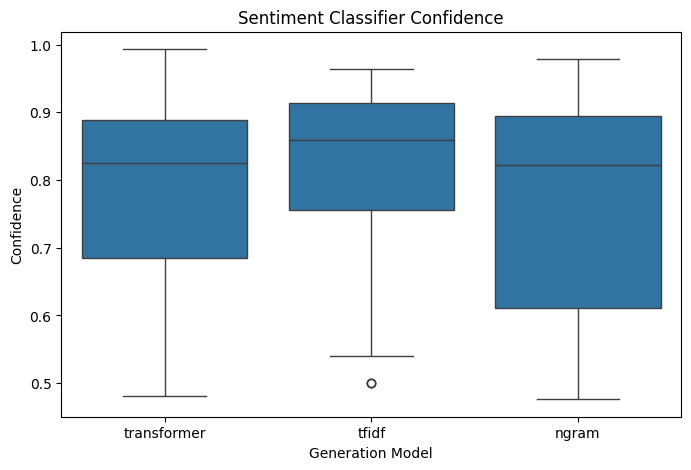

In [55]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df, x="model", y="confidence")
plt.title("Sentiment Classifier Confidence")
plt.ylabel("Confidence")
plt.xlabel("Generation Model")
plt.show()

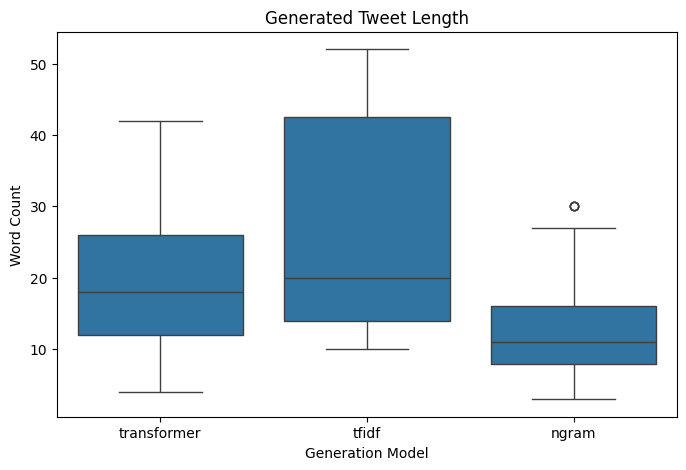

In [56]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df, x="model", y="length")
plt.title("Generated Tweet Length")
plt.ylabel("Word Count")
plt.xlabel("Generation Model")
plt.show()

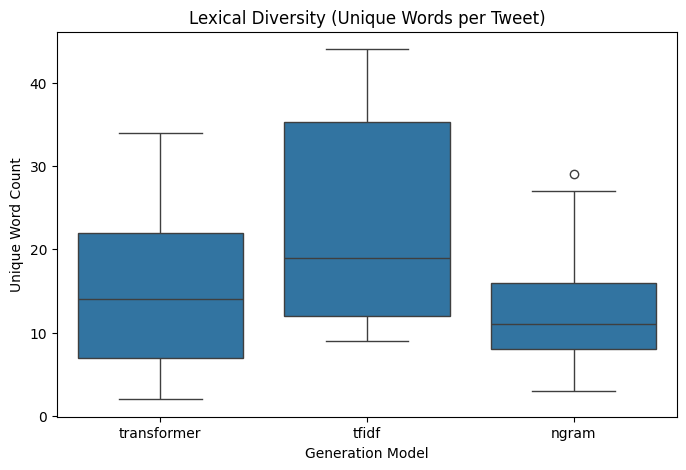

In [57]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df, x="model", y="vocab_size")
plt.title("Lexical Diversity (Unique Words per Tweet)")
plt.ylabel("Unique Word Count")
plt.xlabel("Generation Model")
plt.show()

# 9. Tableau Récapitulatif et Conclusion

Synthèse des performances des différents modèles.

--- 8. Tableau Récapitulatif des Performances ---

Tableau Récapitulatif (trié par F1-score Macro):


,accuracy,precision_macro,recall_macro,f1_macro
Transformer (distilbert-base-uncased),0.804043,0.102729,0.100306,0.792608
Logistic Regression (TF-IDF),0.723192,0.707241,0.706620,0.706677
MLP (TF-IDF),0.717155,0.704365,0.691524,0.696534
Bidirectional LSTM (Improved with fine-tuned Word2Vec),0.696023,0.696351,0.712927,0.691670
Naive Bayes (TF-IDF),0.695761,0.692242,0.655506,0.666051
Random Forest (Best Params),0.668592,0.651776,0.661733,0.655004
Logistic Regression (Word2Vec Avg),0.570547,0.537697,0.539935,0.535881


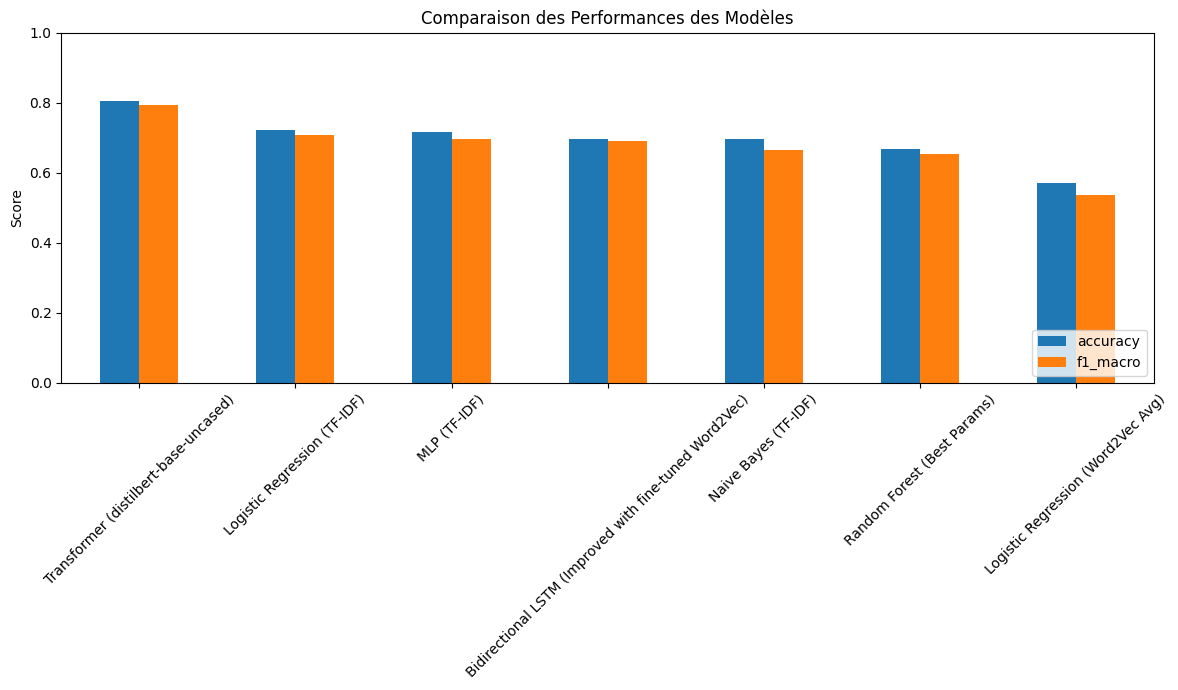

In [76]:
print("--- 9. Tableau Récapitulatif des Performances ---")
results_df = pd.DataFrame.from_dict(results_summary, orient='index')
results_df = results_df.sort_values(by='f1_macro', ascending=False) # Trier par F1-score macro

print("\nTableau Récapitulatif (trié par F1-score Macro):")
display(results_df)

# Visualisation comparative
results_df[['accuracy', 'f1_macro']].plot(kind='bar', figsize=(12, 7), rot=45)
plt.title('Comparaison des Performances des Modèles')
plt.ylabel('Score')
plt.ylim(0, 1) # Scores entre 0 et 1
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# --- Fin du Notebook ---